In [1]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

## MODELO DE OTIMIZAÇÂO ROBUSTA
# Resolver o overfitting (modelos feitos c base no passado)
# Trabalhar com a incerteza!! 
# Orçamento de incerteza

In [2]:
df_ativos=pd.read_csv('retornos_ativos2.csv').set_index(['Date'])
df_ibov=pd.read_csv('retorno_ibov2.csv').set_index(['Date']).dropna()

In [3]:
limite = np.int32(len(df_ativos) / 5 * 4)

retornos_ativo_treino = df_ativos[0:limite]
retornos_ativo_projecao = df_ativos[limite:]
retornos_ibov_treino = df_ibov[0:limite]
retornos_ibov_projecao = df_ibov[limite:]


In [4]:
retornos_ativo_treino.fillna(0, inplace=True)

C:\Users\DECIV\AppData\Local\Temp\ipykernel_14484\882124678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retornos_ativo_treino.fillna(0, inplace=True)


In [5]:
dicio_ativos = {}
for t in range(len(retornos_ativo_treino)):
    for a in range(len(retornos_ativo_treino.columns)):
        dicio_ativos[t,a] = retornos_ativo_treino.iloc[t,a]

dicio_ibov = {}
for t in range(len(retornos_ibov_treino)):
    dicio_ibov[t] = retornos_ibov_treino['IBOV'].iloc[t]



In [6]:
std_ativos = retornos_ativo_treino.std()
std_ativos = pd.DataFrame(std_ativos, columns=['desvio_padrao'])
dicio_std = {}
for a in range(len(retornos_ativo_treino.columns)):
    dicio_std[a] = std_ativos['desvio_padrao'].iloc[a]


## INICIAR MODELO

In [7]:
model = pyo.ConcreteModel()

# RANGE SET
model.A = pyo.RangeSet(0,len(retornos_ativo_treino.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ativo_treino)-1)

# PARAMETROS----------------------
model.ATIVOS = pyo.Param(model.T,model.A, initialize=dicio_ativos)
model.IBOV = pyo.Param(model.T, initialize=dicio_ibov)
model.DELTA = pyo.Param(model.A, initialize = dicio_std)
    ##----------------- GAMA: Orçamento de Incerteza -> Defini quantos ativos podem variar ao mesmo tempo (Seguro geral)
        ##  ------ mutable = True -> define parâmetros que podem ser alterados entre execuções de otimização sem reconstruir o modelo
            ##----model.GAMA = 2.0  # Forma simples  OU model.GAMA.store(2.0)
model.GAMA = pyo.Param(initialize = 3.0, mutable = True)
model.QUANTIDADE_ATIVOS = pyo.Param(initialize = 20.0)

# VARIAVEIS----------------------
model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)
    ## Para cada dia $t$, o modelo precisa de variáveis extras para "absorver" a incerteza: z[t]: Uma variável global de proteção para o dia $t$. p[t, a]: Uma variável de proteção específica para cada ativo no dia $t$.
model.z = pyo.Var(model.T, bounds=(0,None))
model.p = pyo.Var(model.T, model.A, bounds=(0,None))

    #Capturar erro absoluto de cada dia
model.erro = pyo.Var(model.T, bounds=(0,None))

##------------ ALTERAÇÂO DE MSE para MAD 
def erro_pos(model, t):
    return model.erro[t] >= sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t]
def erro_neg(model, t):
    return model.erro[t] >= -(sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t])

model.con_erro_post = pyo.Constraint(model.T, rule=erro_pos)
model.con_erro_neg = pyo.Constraint(model.T, rule=erro_neg)
controle_peso_da_protecao = 0.1

# OBJETIVO----------------------
def func_objetivo_1(model):
    mad = sum(model.erro[t] for t in model.T)
    
    ## Termo de proteção Robusta -----------
    protecao = sum(
        (model.GAMA * model.z[t] + sum(model.p[t,a] for a in model.A)) for t in model.T
    )

    

    return mad + controle_peso_da_protecao*protecao

model.obj = pyo.Objective(rule=func_objetivo_1,sense=pyo.minimize)



In [8]:
# RESTRICOES ----------------------
    ## - Ela diz que a proteção deve ser maior ou igual ao impacto do desvio padrão no peso do ativo
def regra_protecao(model,t,a):
    
    return model.z[t] + model.p[t,a] >= model.DELTA[a] * model.x[a]

model.con_protecao = pyo.Constraint(model.T,model.A, rule=regra_protecao)

    ## OUTRAS RESTRIÇÔES

    # 1- Cardinalidade (total ativos na carteira)
def cardinalidade(model):

    return sum(
        model.y[a] for a in model.A
    ) <= model.QUANTIDADE_ATIVOS
model.cardinalidade = pyo.Constraint(rule=cardinalidade)

    # 2 - Soma peso da carteira
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) == 1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

    # 3 - x só ativa se y=1
def restr_vinculo_x_y(model, a):

    return model.x[a] <= model.y[a]

model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)

    # Retrição de Peso mínimo, se y=1, x deve ser pelo menos 1%
def peso_min(model, a):
    return model.x[a] >= 0.01 * model.y[a]
model.peso_min = pyo.Constraint(model.A, rule=peso_min)




In [9]:
# Antes do solve, dê uma solução inicial ao CPLEX
for a in model.A:
    model.x[a].value = 1/20  # Peso igual para 20 ativos
    model.y[a].value = 1 if a < 20 else 0

In [10]:
opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
opt.options['TimeLimit'] = 480 
# resultado = opt.solve(model)
# opt.options['optimalitytarget'] = 3 ## PARA CASO DE MODELOS NAO LINEARES
opt.options['mip tolerances absmipgap'] = 0.01 
opt.options['mip tolerances mipgap'] = 0.01 
opt.options['mipgap'] = 0.01 

results = opt.solve(model, tee=True, warmstart=True)
print("-------FIM----------")



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\DECIV\AppData\Local\Temp\tmpdk6fxhsf.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> New value for time limit in seconds: 480
CPLEX> New value for absolute mixed integer optimality gap tolerance: 0.01
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> Problem 'C:\Users\DECIV\AppData\Local\Temp\tmpcddflutw.pyomo.lp' read.
Read time = 0.02 sec. (1.51 ticks)
CPLEX> MIP start file 'C:\Users\DECIV\AppData\Local\Temp\tmp3_v0d3hi.cplex.mst' read.
CPLEX> Problem name         : C:\Users\DECIV\AppData\Local\Temp\tmpcddflutw.pyomo.l

           peso_ativo  ativado
VALE3.SA     0.088804      1.0
ITUB4.SA     0.069446      1.0
PETR4.SA     0.063919      1.0
PETR3.SA     0.051005      1.0
SBSP3.SA     0.055214      1.0
B3SA3.SA     0.052581      1.0
ITSA4.SA     0.076927      1.0
BPAC11.SA    0.045679      1.0
WEGE3.SA     0.020400      1.0
BBAS3.SA     0.036109      1.0
EMBJ3.SA     0.032150      1.0
ABEV3.SA     0.041801      1.0
RENT3.SA     0.023537      1.0
VBBR3.SA     0.042106      1.0
AXIA7.SA     0.061178      1.0
BBDC3.SA     0.072813      1.0
TOTS3.SA     0.034725      1.0
ENGI11.SA    0.060985      1.0
AXIA6.SA     0.048423      1.0
USIM5.SA     0.022201      1.0
119.15915732313826
118.17816579616134
117.56706285563654


C:\Users\DECIV\AppData\Local\Temp\ipykernel_14484\2486462711.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_14484\2486462711.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_14484\2486462711.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


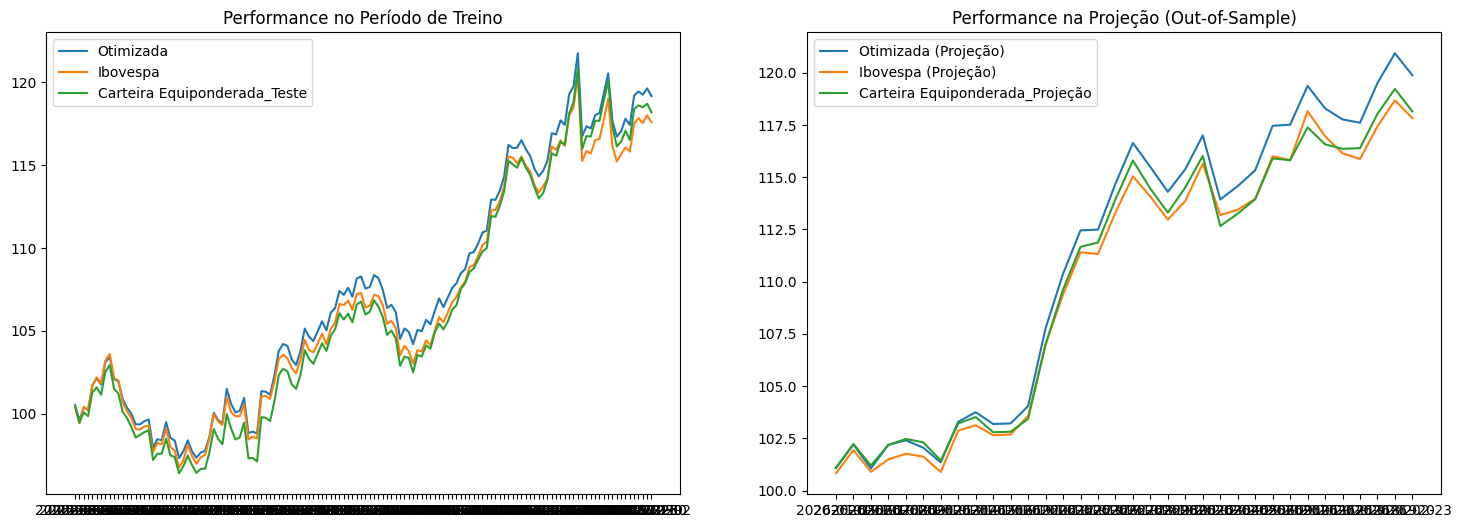

In [12]:
lsita_grande = []
for numero in range(len(retornos_ativo_treino.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativo_treino.columns)
print(final[final['ativado']==1])
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativo_treino[ativos_selecionados]
retornos_carteira_projecao= retornos_ativo_projecao[ativos_selecionados]


carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi
carteira_equi_projecao = retornos_carteira_projecao.mean(axis=1)
carteira_equi_projecao = 1 + carteira_equi_projecao


# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retornos_ibov_treino['IBOV']).cumprod() * 100

# Use os pesos que você já encontrou no modelo
carteira_projecao = (retornos_ativo_projecao[ativos_selecionados] * df_final["peso_ativo"]).sum(axis=1)
acum_projecao = (1 + carteira_projecao).cumprod() * 100
acum_equi_projecao = (carteira_equi_projecao).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

qnt_carteira = pyo.value(model.QUANTIDADE_ATIVOS)
texto = f'Comparação de Performance: Index Tracking ({qnt_carteira} ativos)'

plt.figure(figsize=(18, 6))


# Gráfico 1: Período de Treino
plt.subplot(1, 2, 1)
plt.plot(acum_otimizado, label="Otimizada")
plt.plot(acum_ibov, label="Ibovespa")
plt.plot(acum_equi, label="Carteira Equiponderada_Teste")
plt.title("Performance no Período de Treino")
plt.legend()

# Gráfico 2: Período de Projeção (Out-of-Sample)
plt.subplot(1, 2, 2)
plt.plot(acum_projecao, label="Otimizada (Projeção)")
plt.plot((1 + retornos_ibov_projecao["IBOV"]).cumprod() * 100, label="Ibovespa (Projeção)")
plt.plot(acum_equi_projecao, label="Carteira Equiponderada_Projeção")
plt.title("Performance na Projeção (Out-of-Sample)")
plt.legend()

plt.show()